In [37]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


## Data Visualization

In [38]:
nq_1hr = pd.read_csv("archive/NQ_in_1_hour.csv")
nq_1hr.head()

,datetime,symbol,open,high,low,close,volume
0,2024-01-01 23:00:00,CME_MINI:NQ1!,17019.00,17037.00,17013.75,17029.50,4582.0
1,2024-01-02 00:00:00,CME_MINI:NQ1!,17030.00,17030.75,17018.50,17027.00,2270.0
2,2024-01-02 01:00:00,CME_MINI:NQ1!,17026.75,17038.50,17010.75,17014.50,5255.0
3,2024-01-02 02:00:00,CME_MINI:NQ1!,17014.50,17019.00,17001.00,17008.25,3541.0
4,2024-01-02 03:00:00,CME_MINI:NQ1!,17008.25,17013.00,17002.25,17007.50,2024.0


In [39]:
nq_1hr.isna().sum()

datetime    0
symbol      0
open        0
high        0
low         0
close       0
volume      0
dtype: int64

In [40]:
nq_1hr.describe()

,open,high,low,close,volume
count,10504.000000,10504.000000,10504.000000,10504.000000,10504.000000
mean,20389.144707,20418.951066,20357.336205,20389.719393,24376.404703
std,2054.416148,2052.119516,2056.860219,2054.588696,30782.500048
min,16385.750000,16395.000000,16334.250000,16385.500000,276.000000
25%,18651.000000,18676.000000,18624.375000,18651.000000,3894.000000
50%,20217.000000,20241.375000,20186.000000,20217.375000,7802.000000
75%,21726.062500,21752.125000,21685.062500,21726.250000,40075.750000
max,25379.000000,25394.000000,25363.250000,25378.750000,215784.000000


In [41]:
nq_1hr.drop(columns=["symbol", "datetime"]).corr()

,open,high,low,close,volume
open,1.000000,0.999811,0.999785,0.999688,-0.091214
high,0.999811,1.000000,0.999600,0.999808,-0.083198
low,0.999785,0.999600,1.000000,0.999808,-0.101532
close,0.999688,0.999808,0.999808,1.000000,-0.092779
volume,-0.091214,-0.083198,-0.101532,-0.092779,1.000000


In [42]:
nq_1hr['datetime'] = pd.to_datetime(nq_1hr['datetime'])

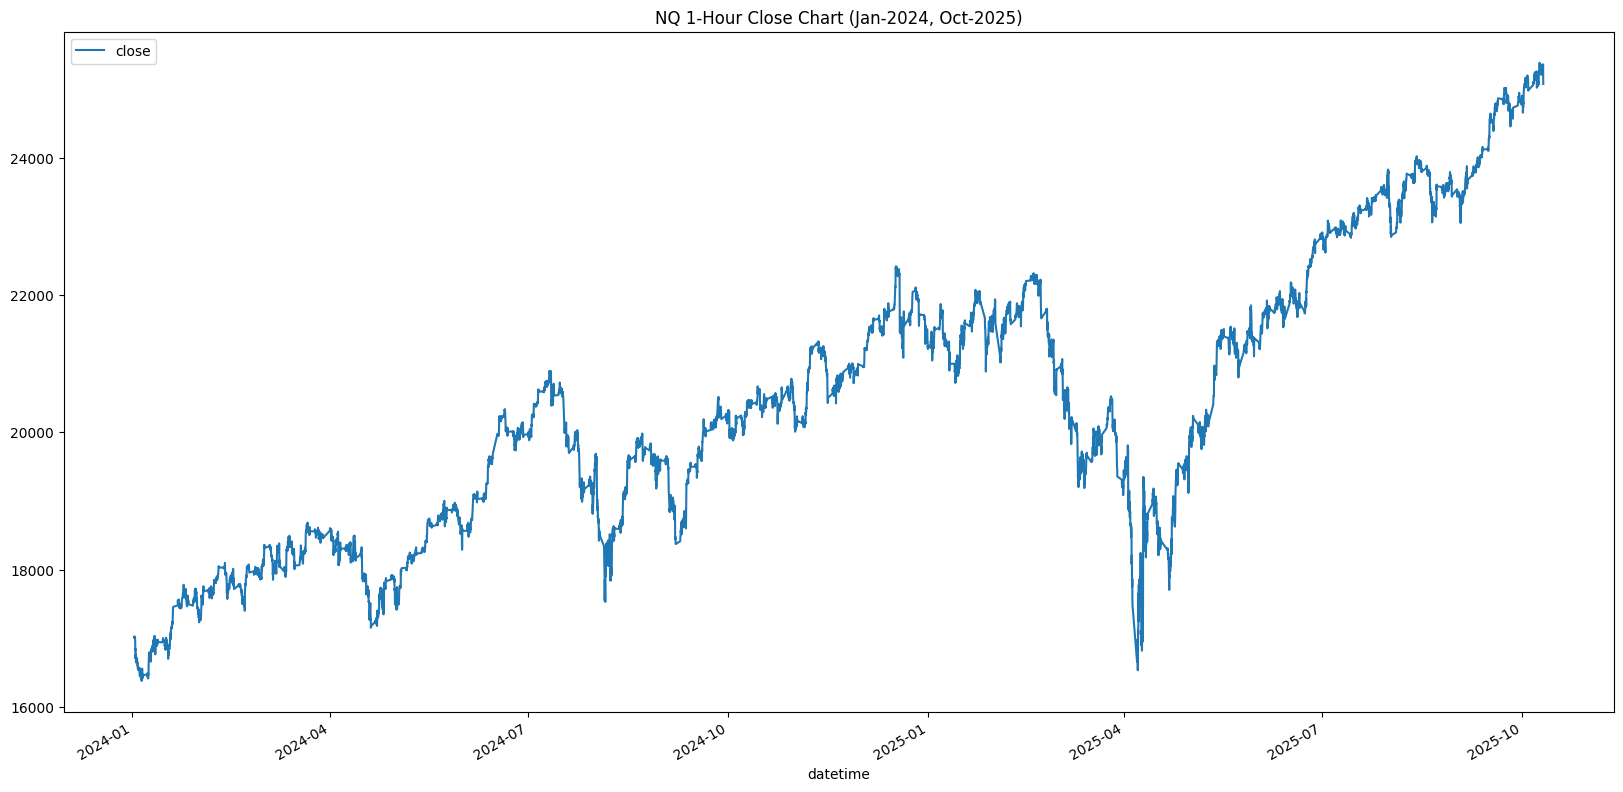

In [43]:
nq_1hr.plot(title="NQ 1-Hour Close Chart (Jan-2024, Oct-2025)",figsize=(20,10), x="datetime", y="close")
plt.show()

### For this Regression I will attempt to predict the next hours closing price from the Open/High/Low/Close/Volume of the previous hour.

In [44]:
nq_1hr['next_close'] = nq_1hr.close.shift(-1)
nq_1hr = nq_1hr.dropna()

In [55]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import root_mean_squared_error, r2_score, mean_absolute_error

lm = LinearRegression()
tscv = TimeSeriesSplit(n_splits=5)
def lm_train_cv(X, y):
    for i, (train_index, test_index) in enumerate(tscv.split(nq_1hr)):
        print(f"Fold {i}:")
        lm.fit(X.iloc[train_index], y.iloc[train_index])

        y_hat = lm.predict(X.iloc[test_index])
        mae = mean_absolute_error(y.iloc[test_index], y_hat)
        rmse = root_mean_squared_error(y.iloc[test_index], y_hat)
        r2 = r2_score(y.iloc[test_index], y_hat)
        print("MAE: ", mae)
        print("RMSE:", rmse)
        print("R_Squared", r2)
        plt.scatter(X.close.iloc[test_index], y.iloc[test_index], color = "red", label = "Actual")
        plt.plot(X.close.iloc[test_index], y_hat, label = "Predicted")
        plt.ylabel("next_close")
        plt.xlabel("close")
        plt.legend()
        plt.show()
    

Fold 0:
MSE:  1814.8483481220273
RMSE: 42.60103693716888
R_Squared 0.9980885375612429


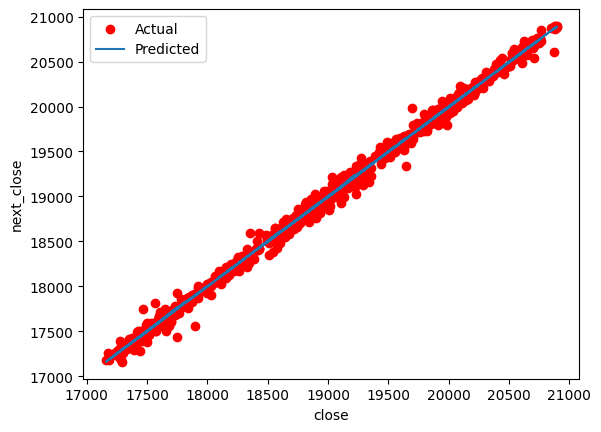

Fold 1:
MSE:  2306.1874816307723
RMSE: 48.02278086107439
R_Squared 0.9960901801606226


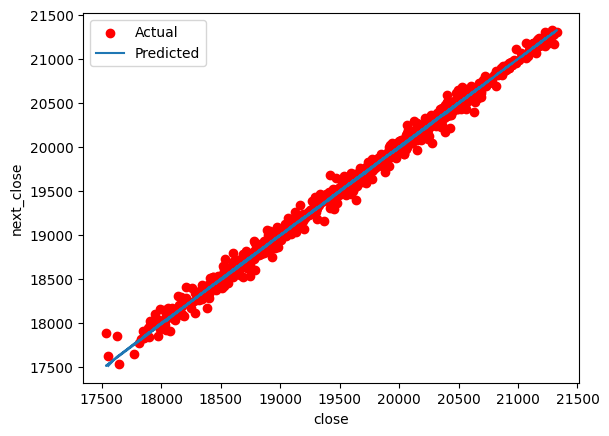

Fold 2:
MSE:  3039.0175510404138
RMSE: 55.12728499609258
R_Squared 0.9883940972568677


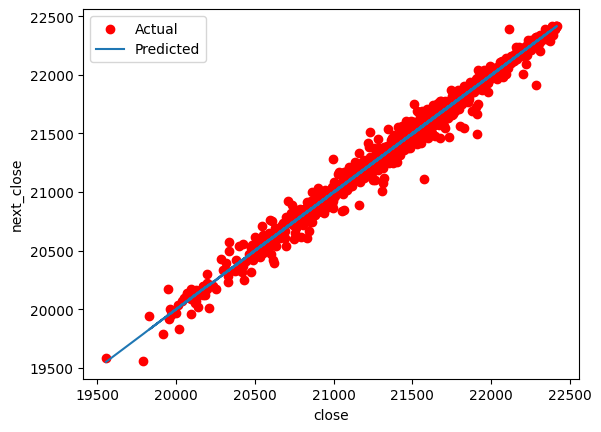

Fold 3:
MSE:  6909.773253108299
RMSE: 83.12504588334552
R_Squared 0.996005276699601


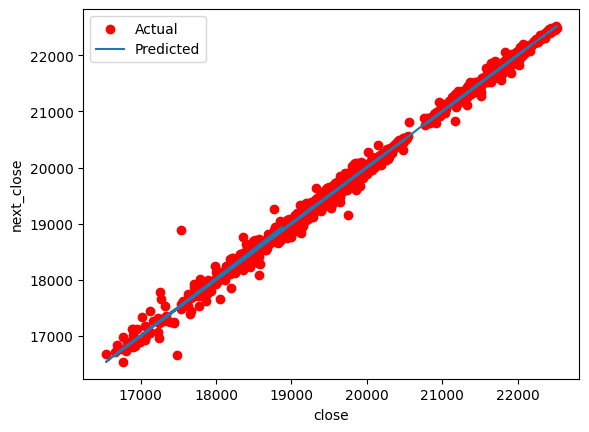

Fold 4:
MSE:  1487.7130600367668
RMSE: 38.570883578636966
R_Squared 0.9972889129132068


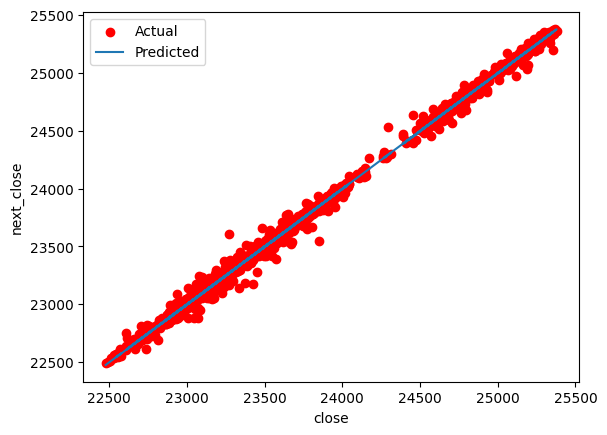

In [46]:
X = nq_1hr.drop(columns=["next_close", "datetime", "symbol"])
y = nq_1hr["next_close"]

lm_train_cv(X, y)

## Experiment 2: Adding time based features

In [47]:
nq_1hr["year"] = nq_1hr.datetime.dt.year
nq_1hr["month"] = nq_1hr.datetime.dt.month
nq_1hr["day"] = nq_1hr.datetime.dt.day
nq_1hr["dayofweek"] = nq_1hr.datetime.dt.dayofweek
nq_1hr["hour"] = nq_1hr.datetime.dt.hour
nq_1hr["quarter"] = nq_1hr.datetime.dt.quarter
nq_1hr = nq_1hr.set_index(nq_1hr["datetime"]).drop(columns="datetime")

Since all of the time based features are cyclical, they must be encoded so that they have the same distance from the largest to smallest

In [48]:
def encode_cyclical(data: pd.DataFrame, columns: list):

    for column in columns:
        if column in data.columns:
            data[column + "_sin"] = np.sin(2 * np.pi * data[column]/np.max(data[column]))
            data[column + "_cos"] = np.cos(2 * np.pi * data[column]/np.max(data[column]))
            data = data.drop(columns=column)
        else:
            print(f"Could not encode column: {column}")
    return data

In [49]:
nq_1hr = encode_cyclical(nq_1hr, ["year", "month", "day", "hour", "quarter", "dayofweek"])

Fold 0:
MSE:  2731.4963055908133
RMSE: 52.26371882664697
R_Squared 0.9971230915271001


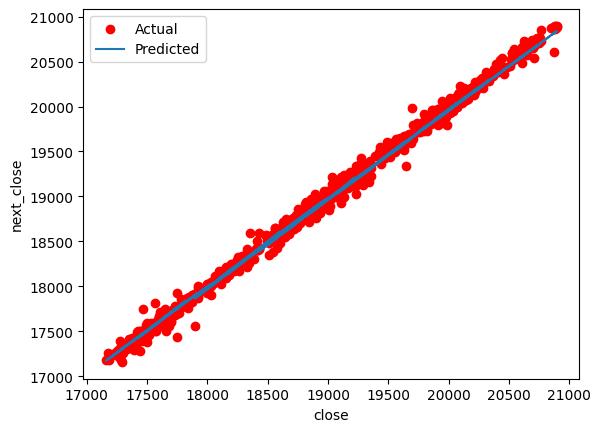

Fold 1:
MSE:  2387.832317020529
RMSE: 48.86545115949027
R_Squared 0.9959517627076913


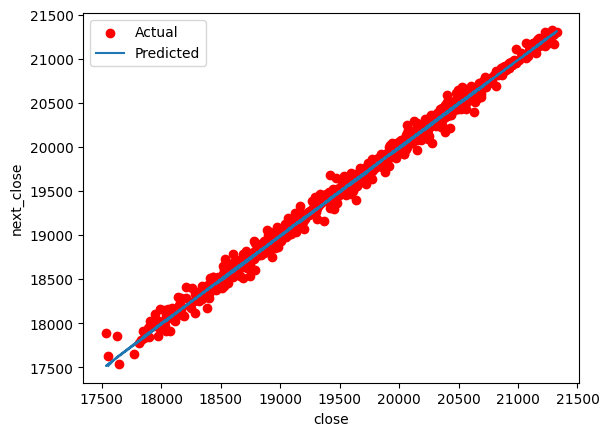

Fold 2:
MSE:  3080.089407934554
RMSE: 55.49855320577784
R_Squared 0.98823724525829


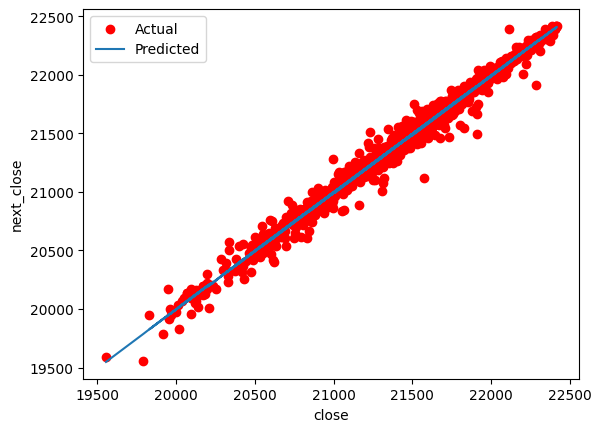

Fold 3:
MSE:  6911.013688921392
RMSE: 83.13250681244607
R_Squared 0.9960045595707367


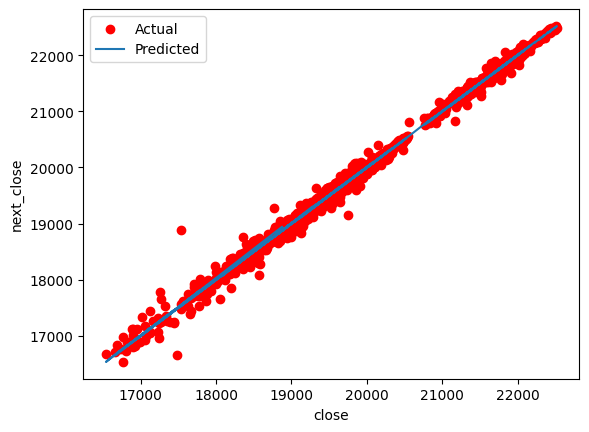

Fold 4:
MSE:  1482.7931846817664
RMSE: 38.50705370035166
R_Squared 0.9972978784932651


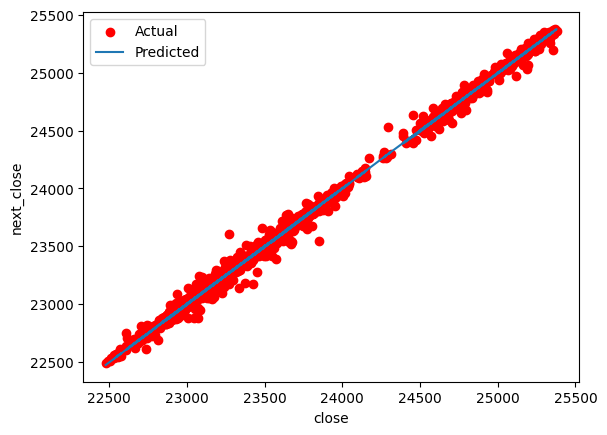

In [50]:
X = nq_1hr.drop(columns=["symbol", "next_close"])
y = nq_1hr["next_close"]

lm_train_cv(X,y)

## Experiment 3: Seasonal and Trend Decomposition using LOESS

In [51]:
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller

In [52]:
def encode_seasonality(data: pd.DataFrame, column: str, period: int):

    if column in data.columns:
        stl = STL(endog=data[column], period=period)
        res = stl.fit()
        adf = adfuller(res.resid)
        data[column + "_trend"] = res.trend
        data[column + "_season"] = res.seasonal
        data[column + "_residual"] = res.resid
        if adf[1] > 0.5:
            print(f"P-Value > 0.5: No stationarity found for {column}")
        else:
            print(f"P-Value < 0.5: Stationarity found for {column}")
    else:
        print(f"Could not encode column: {column}")

    return data


In [53]:
nq_1hr = encode_seasonality(nq_1hr, "close", 24)

P-Value < 0.5: Stationarity found for close


Fold 0:
MSE:  1810.252605336586
RMSE: 42.54706341613468
R_Squared 0.9980933779600132


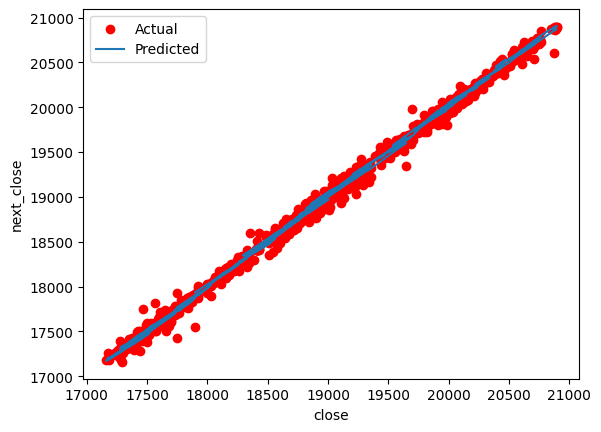

Fold 1:
MSE:  2031.1127528676438
RMSE: 45.06786829735398
R_Squared 0.9965565310711171


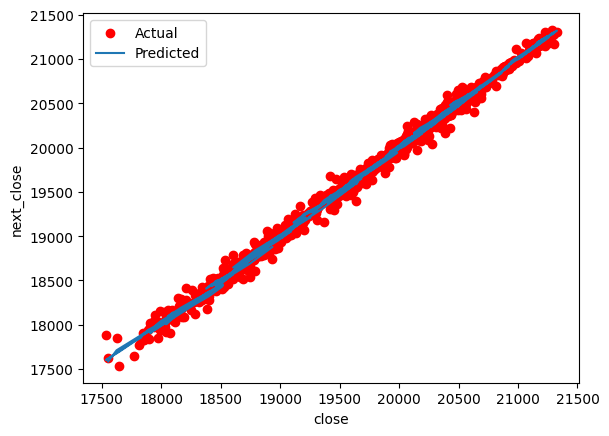

Fold 2:
MSE:  2689.3088880084642
RMSE: 51.85854691377752
R_Squared 0.9897296225256146


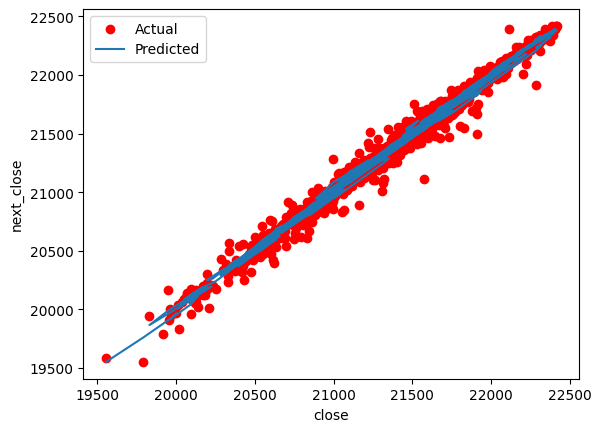

Fold 3:
MSE:  6291.099954540734
RMSE: 79.31645450056838
R_Squared 0.9963629481528591


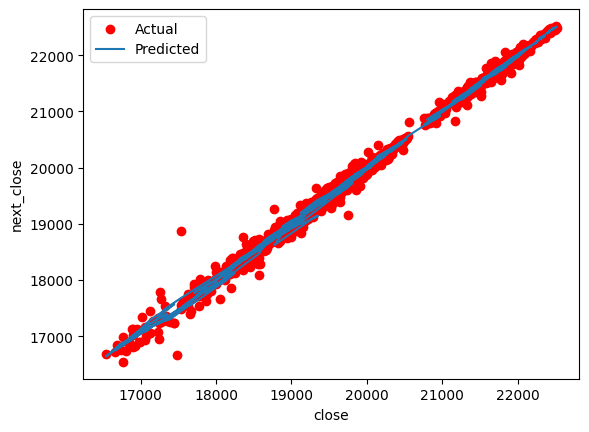

Fold 4:
MSE:  1310.0906568320027
RMSE: 36.19517449649888
R_Squared 0.9976125975111236


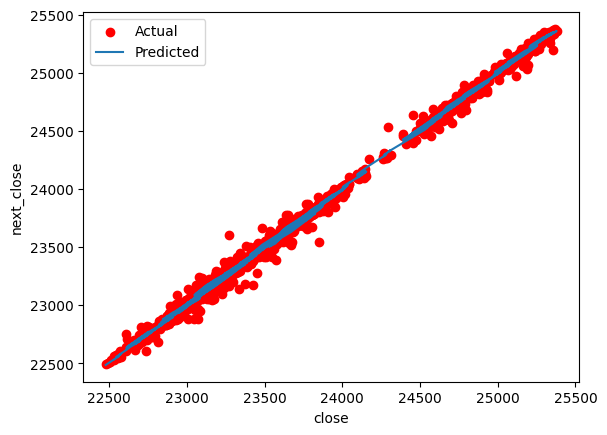

In [54]:
X = nq_1hr.drop(columns=["symbol", "next_close"])
y = nq_1hr["next_close"]

lm_train_cv(X,y)